# Interview CaseStudy

The attached data is of customers who had taken loan from a Bank. There are independent attributes computed from Bureau and Demographics. 

Dependant variable name: (30_DPD_F3M or BOUNCE_F3M) Build a binary classification model using this bad definition.
Use any binary classification technique you are comfortable with, use any coding language.

There are two files with independent features, join the files using the common key available in data.

1. Publish Univariate statistics for numerical variables

2. Publish distribution for categorical variables

3. Publish how many missing values and special values are there for each of the independent variables

4. Present the model keeping business users in mind.

#### Data Science Life Cycle - CRISP-DM

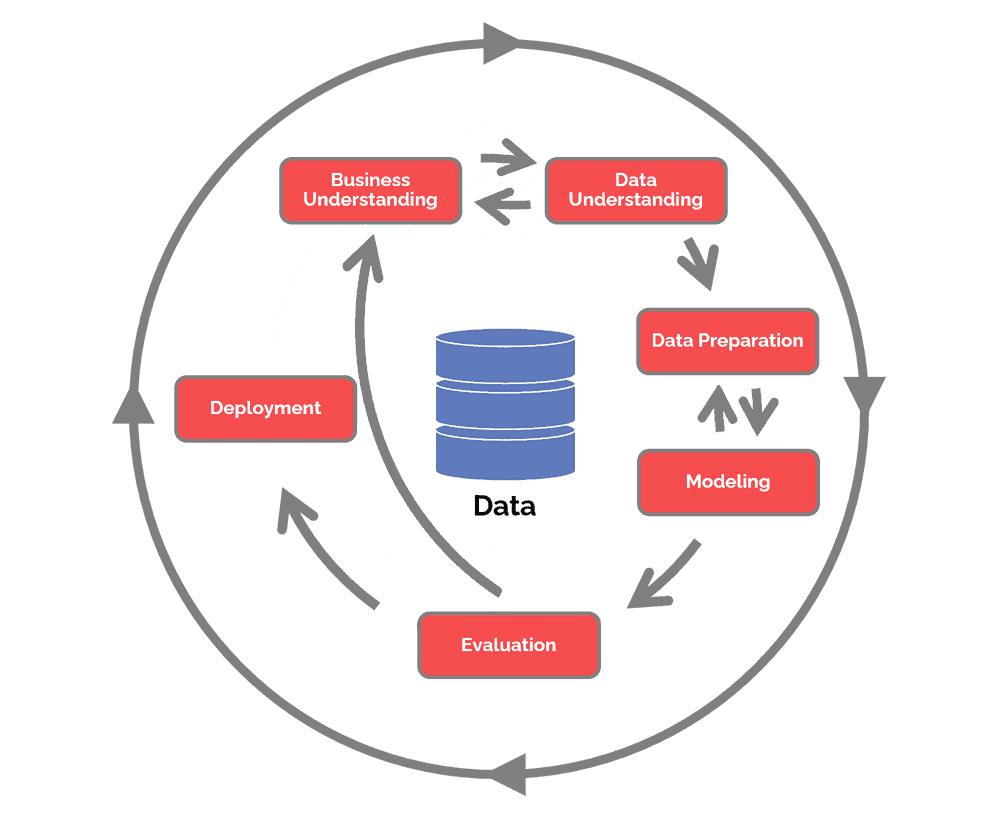

# IMPORT Libraries

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Other Dependent Libraries
from sklearn import tree

from sklearn.model_selection import RepeatedStratifiedKFold,  RepeatedKFold

from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.feature_selection import f_regression

from sklearn.feature_selection import SelectKBest

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.tree import DecisionTreeClassifier

from collections import Counter

from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler

# GET the Data, Join and preprocessing

In [56]:
df = pd.read_excel('CaseStudy/clean_df.xls')

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.tail()

## Install XG Boost (Boosting Algorithm for Feature selection tool Boruta)

In [ ]:
# !pip install xgboost

In [ ]:
# !pip install Boruta

# Scaling the data to make ML model ready

Machine Learning models input the scaled inputs for processing. Each feature can be considered as an independent vector making up a whole matrix. Independence is checked through several means and after rigorous checks and confirmation important principal features are finalised.


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

In [ ]:
X_train = scaler.transform(X_train)

In [ ]:
X_test = scaler.transform(X_test)

### Feature Selector using Boruta algorithm

In [ ]:
import xgboost as xgb

from boruta import BorutaPy

Using XGBoost classifier for Boruta model.

Boruta Model --> a number of randomly shuffled shadow attributes are created to establish the baseline performance. A hypothesis test is then used to determine whether a variable is only randomly correlated or carries significant information. This test, by default, is carried out with a significance level of .05, this can be changed using the alpha argument when creating a BorutaPy object. 

In [ ]:
import multiprocessing
n_jobs = multiprocessing.cpu_count()
print(n_jobs)

In [ ]:
model = xgb.XGBClassifier(eval_metric = 'merror' , n_jobs = -5, seed = 6)

feature_select = BorutaPy(model, n_estimators='100', verbose=2, random_state=6)

In [ ]:
feature_select.fit(X_train,y_train)

In [ ]:
feature_names = list(zip(df.columns,feature_select.ranking_,feature_select.support_))

feature_boruta = pd.DataFrame(feature_names, columns=['Columns','Ranks', 'T/F'])

In [ ]:
feature_boruta[feature_boruta['T/F']==True]

### Transforming the X_train and X_test after feature selection using Boruta 

In [ ]:
X_train_brt = feature_select.transform(X_train)

X_train_brt.shape

In [ ]:
X_test_brt = feature_select.transform(X_test)

X_test_brt.shape

# XGBoost Model

### First Try with default settings

In [ ]:
import xgboost as xgb2

xgb_model = xgb2.XGBClassifier()

xgb_model.fit(X_train_brt,y_train)

### Failed in classifying

In [ ]:
y_hat_xgb = xgb_model.predict(X_test_brt)

print("Training Set Score ", xgb_model.score(X_train_brt,y_train)*100,"%")

print("Test Set score ",xgb_model.score(X_test_brt,y_test)*100,"%")

### Second Try with manual settings

Source code for following : https://towardsdatascience.com/selecting-optimal-parameters-for-xgboost-model-training-c7cd9ed5e45e 

In [ ]:
from sklearn.model_selection import GridSearchCV as GSV

import time

eval_set = [(X_train_brt, y_train), (X_test_brt, y_test)]

estimators = [100, 200]

depth = [10, 15]

eta = [ 0.03, 0.05]

g = [10, 11, 12, 13]

childweight = [ 5, 9, 15, 20, 25]

C = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]

param_grid = dict(n_estimators = estimators, max_depth = depth, learning_rate = eta, min_child_weight = childweight, gamma = g)

xgb_model = xgb2.XGBClassifier(verbose = 2, subsample = 0.33);

grid = GSV(estimator= xgb_model, param_grid= param_grid, cv = 4, n_jobs= -5)

start_time = time.time()

grid_result = grid.fit(X_train_brt, y_train.values.ravel(), early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

In [ ]:
xgb_model = xgb2.XGBClassifier(verbose=2, gamma = 10, learning_rate = 0.05, max_depth = 10, min_child_weight = 15, n_estimators = 200)

xgb_model.fit(X_train_brt,y_train)

In [ ]:
y_hat_xgb = xgb_model.predict(X_test_brt)

print("Training Set Accuracy Score ", xgb_model.score(X_train_brt,y_train)*100,"%")

print("Test Set Accuracy score ",xgb_model.score(X_test_brt,y_test)*100,"%")

In [ ]:
print("Classification Report for the XGBoost model \n",classification_report(y_test,y_hat_xgb))

In [ ]:
y_score_xgb = xgb_model.predict_proba(X_test_brt)

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_test,
    y_score_xgb[:,1],
    name="0 vs 1",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.6)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [ ]:
cm = confusion_matrix(y_test,y_hat_xgb)

sns.heatmap(cm,annot=True,fmt = '.1f', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Logistic Regression Model - Failed / Scrap

In [ ]:
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

c = [2.0, 3.0, 4.0, 5.0, 6.0, 6.5, 7.0, 7.5, 8.0]

param_grid = dict(solver = solver, C = c)

lr = LogisticRegression(random_state = 6 ,max_iter=1000, verbose=2) #if used l1 regularisation features will also filtered

grid_lr = GSV(estimator= lr, param_grid=param_grid, cv = 4, n_jobs=-5)

grid_result_lr = grid_lr.fit(X_train_brt, y_train)

print("Best score: %f using %s"%(grid_result_lr.best_score_, grid_result_lr.best_params_))

In [ ]:
lr_model = LogisticRegression(random_state=6, C = 2, max_iter = 1000, solver='newton-cg', verbose = 1)

lr_model.fit(X_train_brt, y_train)

y_hat_lr = lr_model.predict(X_test_brt)

print("Training Set Score ", lr_model.score(X_train_brt,y_train)*100,"%")

print("Test Set score ",lr_model.score(X_test_brt,y_test)*100,"%")

print("Classification Report for the LR model \n",classification_report(y_test,y_hat_lr))

In [ ]:
print("Confusion Matrix for LOGISTIC REGRESSION MODEL")
pd.DataFrame(confusion_matrix(y_test,y_hat_lr),columns=['Pred 0','Pred 1'], index=['Actual 0', 'Actual 1'])

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_hat_lr), annot=True, fmt='.2f', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
y_score = lr_model.predict_proba(X_test_brt)

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_test,
    y_score[:,1],
    name="0 vs 1",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.58)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Decision Tree Model

In [ ]:
try:
       
    model_tree_brt = DecisionTreeClassifier(criterion = 'entropy', max_depth=5)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=6)
    
    cv_score = cross_val_score(model_tree_brt,X_train_brt, y_train, cv = cv, scoring='roc_auc')

except Exception as e:
    print(e)

In [ ]:
np.mean(cv_score)

In [ ]:
try:
    model_tree_brt.fit(X_train_brt, y_train) # for training

    y_hat_dt = model_tree_brt.predict(X_test_brt)

    print("Print Training set score for DT model ", model_tree_brt.score(X_train_brt,y_train)*100,"%")

    print("Classification Report for the DT model \n",classification_report(y_test,y_hat_dt))
    
    plt.figure(figsize=(25,10), dpi=80)
    
    tree.plot_tree(model_tree_brt,max_depth=5,feature_names=feature_boruta.Columns)

except Exception as e:
    print(e)

In [ ]:
print("Confusion Matrix for DT MODEL")
pd.DataFrame(confusion_matrix(y_test,y_hat_dt),columns=['Pred 0','Pred 1'], index=['Actual 0', 'Actual 1'])

In [ ]:
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score

In [ ]:
X_train_sm = sm.add_constant(X_train)

In [ ]:
try:
    lr_model_2 = sm.OLS(y_train, X_train_sm)
    lr_model_sm = lr_model_2.fit()
    print(lr_model_sm.summary())
    print(lr_model_sm.summary2())
except Exception as e:
    print(e)

# Feature selection alternative - SelectKBest

As we see there are several features in dataset with p-values over 0.05. We need to select suitable 

features using regression so that highly correlated ie p-value <0.05

In [ ]:
get_features_kbest = SelectKBest(score_func=f_regression, k=5)

get_features_kbest.fit(X_train,y_train)

In [ ]:
X_train_kb = get_features_kbest.transform(X_train)

In [ ]:
X_test_kb = get_features_kbest.transform(X_test)

# XGBoost Model with features selected using K Best 

In [ ]:
import xgboost as xgb3

eval_set = [(X_train_kb, y_train), (X_test_kb, y_test)]

estimators = [100, 200]

depth = [10, 15]

eta = [0.03, 0.05]

g = [10, 11, 12, 13]

childweight = [ 5, 9, 15, 20, 25]

C = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]

param_grid = dict(C = C, n_estimators = estimators, max_depth = depth, learning_rate = eta, min_child_weight = childweight, gamma = g)

xgb_model3 = xgb3.XGBClassifier(subsample = 0.33)

grid_kb = GSV(estimator= xgb_model3, param_grid = param_grid, n_jobs=-5)

grid_result_2 = grid_kb.fit(X_train_kb, y_train.values.ravel(), early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set)

print("score :%f, using %s"%(grid_result_2.best_score_, grid_result_2.best_params_))

In [ ]:
xgb_model2.fit(X_train_kb,y_train)

y_hat_kb = xgb_model2.predict(X_test_kb)

In [ ]:
print("Training Set Accuracy Score ", xgb_model2.score(X_train_kb,y_train)*100,"%")

print("Test Set Accuracy score ",xgb_model2.score(X_test_kb,y_test)*100,"%")

In [ ]:
print(classification_report(y_test,y_hat_kb))

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_hat_kb), annot=True, fmt = '.1f',xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
counter = Counter(y_test)
print(counter)

No significant improvements found in the classifier using K best (f_regression - which is univariate linear regression model and orders correlation of predictors with target based on p-value)

OR

# Bagging Classifier using Decision Tree

This classifier has a tendency to overfit the data. You may see the models below where all of them are poor in predicting based on unseen data.

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
seed = 6

kfold = KFold( n_splits=10, random_state=seed , shuffle=True)

In [ ]:
dt_kfold = DecisionTreeClassifier()

baggingclf_dt_kfold = BaggingClassifier(base_estimator=dt_kfold, random_state=seed, n_estimators = 100, verbose=2)

In [ ]:
results = cross_val_score( baggingclf_dt_kfold, X_train, y_train, cv=kfold ,scoring='roc_auc')

In [ ]:
for i in range(len(results)):
    print("Model: "+str(i)+", Accuracy : " +str(results[i]))

In [ ]:
print("Mean Accuracy :"+str(results.mean()))

In [ ]:
model_dt_bag = baggingclf_dt_kfold.fit( X_train, y_train)

In [ ]:
y_hat_bag = model_dt_bag.predict(X_test)

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_hat_bag), annot=True, fmt = '.1f',xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

### Fitting model with X_train_brt - features selected by Boruta.

The kind of features shortlisted by Boruta must be tried with Bagging technique.

In [ ]:
model_dt_bag_2 = baggingclf_dt_kfold.fit( X_train_brt, y_train)

y_hat_bag_2 = model_dt_bag_2.predict(X_test_brt)

sns.heatmap(confusion_matrix(y_test,y_hat_bag_2), annot=True, fmt = '.1f',xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

### Fitting model with X_train_kb - features selected using KBest - f_regression as its underlying model

In [ ]:
model_dt_bag_3 = baggingclf_dt_kfold.fit( X_train_kb, y_train)

y_hat_bag_3 = model_dt_bag_3.predict(X_test_kb)

sns.heatmap(confusion_matrix(y_test,y_hat_bag_3), annot=True, fmt = '.1f',xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
model_dt_bag_3.n_features_in_

In [ ]:
y_score_prob_kb = model_dt_bag_3.predict_proba(X_test_kb)
y_score_prob_brt = model_dt_bag_2.predict_proba(X_test_brt)

In [ ]:
RocCurveDisplay.from_predictions(
    y_test,
    y_score_prob_kb[:,1],
    name="0 vs 1",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.55)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### Fitting the bagging model using RFE filtered features:

In [ ]:
model_dt_bag_4 = baggingclf_dt_kfold.fit( X_train_rfe, y_train)

y_hat_bag_4 = model_dt_bag_4.predict(X_test_rfe)

sns.heatmap(confusion_matrix(y_test,y_hat_bag_4), annot=True, fmt = '.1f',xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])